In [1]:
import bs4 as bs
import pandas as pd
import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By 
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import numpy as np

In [2]:
def get_results(tech=None, market=None, stage=None):
    
    url = 'https://angel.co/companies?company_types[]=Startup&company_types[]=Private+Company&company_types[]=SaaS&company_types[]=Mobile+App'
    if tech:
        url = url + '&teches[]=' + tech
    if market:
        market = market.replace(' ', '+')
        url = url + '&markets[]=' + market
    if stage:
        url = url + '&stage=' + stage

    url = url + '&raised[min]=1000&raised[max]=100000000000'
    options = webdriver.ChromeOptions()
    options.add_argument('headless')
    
    driver = webdriver.Chrome()

    driver.set_window_size(3000, 1000)
    driver.get(url)
    time.sleep(5)
    
    sortby_raised = driver.find_element_by_xpath("//div[@class='column raised sortable']")

    sortby_raised.click()
    time.sleep(5)
    
    source = driver.page_source
    
    while True:
        try:
            source = driver.page_source
            loadMoreButton = driver.find_element_by_class_name('more').click()
            time.sleep(3)
        except: 
            break
            
    driver.close()

    try:
        soup = bs.BeautifulSoup(source, 'lxml')
        result_list =  soup.find_all('div', {'class': 'results'})[0]
        results = result_list.find_all('div', {'data-_tn': 'companies/row'})
    except:
        print('Could not get results')
        return

    
    return results

In [3]:
def parse_results(results):
    df = pd.DataFrame(columns=['kind', 'link', 'name', 'pitch', 'joined', 
                               'location', 'market', 'size', 'stage', 'raised'],
                  index=[0])
    
    for result in results[1:]:
        try:
            dic = {}
            try:
                dic['kind'] = result.a['data-type']
            except: dic['kind'] = None

            try:
                dic['link'] = result.a['href']
            except: dic['link'] = None

            try:
                dic['name'] = result.a['title']
            except: dic['name'] = None
                
            try:
                dic['website'] = result.find('div', {'data-column': 'website'}).text.split()[1]
            except: dic['website'] = None

            try:
                dic['pitch'] = result.find('div', {'class': 'pitch'}).text
            except: dic['pitch'] = None

            try:
                dic['joined'] = result.find('div', {'data-column': 'joined'}).text.split('Joined')[1].strip()
            except: dic['joined'] = None

            try:
                dic['location'] = result.find('div', {'data-column': 'location'}).text.split('Location')[1].strip()
            except: dic['location'] = None

            try:
                dic['market'] = result.find('div', {'data-column': 'market'}).text.split('Market')[1].strip()
            except: dic['market'] = None

            try:
                dic['size'] = result.find('div', {'data-column': 'company_size'}).text.split()[1]
            except: dic['size'] = None

            try:
                dic['stage'] = result.find('div', {'data-column': 'stage'}).text.split('Stage')[1].strip()
            except: dic['stage'] = None

            try:
                dic['raised'] = result.find('div', {'data-column': 'raised'}).text.split('Raised')[1].strip()
            except: dic['raised'] = None
            
            
            df = df.append(pd.DataFrame(dic, index=[0]))

        except: pass

    df = df.reset_index(drop=True)
    return df



def get_companies(tech=None, market=None, stage=None):
    results = get_results(tech, market, stage)
    if results:
        df = parse_results(results)
        return df

In [5]:
get_companies(tech="HTML5", market="Healthcare", stage=None)

,kind,link,name,pitch,joined,location,market,size,stage,raised,website
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Startup,https://angel.co/company/drchrono,DrChrono,\nOn a mission to fix healthcare\n,Feb ’11,Sunnyvale,Medical Devices,51-200,Series A,"$48,725,000",drchrono.com
2,Startup,https://angel.co/company/seamless-medical-systems,Seamless Medical Systems,\niPad patient registration and health informa...,Aug ’11,Santa Fe,Healthcare,1-10,-,"$3,000,000",seamlessmedical.com
3,Startup,https://angel.co/company/fit3d,Fit3D,"\nUsing 3D scanners, resulting data, and predi...",Feb ’13,San Mateo,Fitness,11-50,Seed,"$5,390,000",fit3d.com
4,Startup,https://angel.co/company/wildflower-health,Wildflower Health,\nMobile programs that make healthcare smarter\n,Dec ’12,San Francisco,Mobile Health,11-50,Series B,"$5,100,000",wildflowerhealth.com
...,...,...,...,...,...,...,...,...,...,...,...
58,Startup,https://angel.co/company/sportly-2,SPORTLY,\nthe business booster for fitness professiona...,Feb ’15,Klagenfurt,Fitness,1-10,Closed,"€115,000",sportly.co
59,Startup,https://angel.co/company/bairo,Bairo,\nRedefining healthcare by data\n,Nov ’15,Tampa,SaaS,11-50,Seed,"$125,000",bairocorp.com
60,Startup,https://angel.co/company/futbol-fit-club-1,Futbol Fit Club,\nWe are Zumba for soccer fans\n,Jun ’16,Bogota,Fitness,1-10,Seed,"$70,000",futbolfitclub.com
61,Startup,https://angel.co/company/simplifit,SimpliFit,\nWeight Loss for the 21st Century\n,Nov ’13,San Francisco,Fitness,1-10,Seed,"$20,000",getSimpliFit.com


In [6]:
import datetime
datetime.datetime.now()

datetime.datetime(2020, 5, 26, 13, 12, 46, 273585)

In [7]:
filename="angelist_"+str(datetime.datetime.now())[:-7].replace(":","_").replace(" ","_")+".csv"
filename

'angelist_2020-05-26_13_12_46.csv'

In [8]:
filename="C:/Users/daswa/Desktop/Data Science Projects/Healthcare_Startup_Assessment/data/raw/angelist_"+str(datetime.datetime.now())[:-7].replace(":","_").replace(" ","_")+".csv"

techs = ['Python', 'Javascript', 'HTML5', 'Java', 'CSS', None]

markets = [ "Healthcare"]


df = pd.DataFrame()

for tech in techs:
    for market in markets:
        print(tech, market)

        try:
            companies = get_companies(tech, market, None)
#                 companies['query'] = query
#                 companies['type_'] = type_
#                 companies['stage'] = stage
#                 companies['tech'] = tech
            print('- Got companies')
        except Exception as e: 
            companies = pd.DataFrame()
            print('!! Could not get companies')
            print(e)
            pass

        try:
            if df.empty:
                df = companies
            else:
                df = df.append(companies)
            print("- Added {} rows".format(companies.shape[0]))
            print("- Total rows: {}".format(df.shape[0]))
        except:
            print('!! Unable to append new data.')
            pass

    df = df.reset_index(drop=True)
    df.to_csv(filename)
    print("-"*50)

            
df = df.reset_index(drop=True)
df.to_csv(filename)

Python Healthcare
- Got companies
- Added 99 rows
- Total rows: 99
--------------------------------------------------
Javascript Healthcare
- Got companies
- Added 134 rows
- Total rows: 233
--------------------------------------------------
HTML5 Healthcare
- Got companies
- Added 63 rows
- Total rows: 296
--------------------------------------------------
Java Healthcare
- Got companies
- Added 52 rows
- Total rows: 348
--------------------------------------------------
CSS Healthcare
- Got companies
- Added 35 rows
- Total rows: 383
--------------------------------------------------
None Healthcare
- Got companies
- Added 401 rows
- Total rows: 784
--------------------------------------------------


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from collections import Counter

In [54]:

comp = pd.read_csv('C:/Users/daswa/Desktop/Data Science Projects/Healthcare_Startup_Assessment/data/raw/angelist_2020-05-26_13_12_47.csv')
comp = comp[ comp.stage.notna() & comp.name.notna() ]

In [55]:
comp.head()

,Unnamed: 0,kind,link,name,pitch,joined,location,market,size,stage,raised,website
1,1,Startup,https://angel.co/company/drchrono,DrChrono,\nOn a mission to fix healthcare\n,Feb ’11,Sunnyvale,Medical Devices,51-200,Series A,"$48,725,000",drchrono.com
2,2,Startup,https://angel.co/company/classpass,ClassPass,\nOne app for the best fitness classes\n,Jul ’11,Sydney,Fitness,501-1000,Series C,"$84,000,000",classpass.com
3,3,Startup,https://angel.co/company/fabricgenomics,Fabric Genomics,\nGlobal healthcare platform for genomics-driv...,Jul ’13,Oakland,Bioinformatics,11-50,Series B,"$23,000,000",fabricgenomics.com
4,4,Startup,https://angel.co/company/chewse,Chewse,"\nProvides hassle-free, locally-sourced, delic...",Jan ’12,Austin,Hospitality,51-200,Series B,"$16,000,000",chewse.com
5,5,Startup,https://angel.co/company/syapse,Syapse,\nPowering precision medicine with insights fr...,Feb ’12,Radnor,Bioinformatics,51-200,Series C,"$59,500,000",syapse.com


In [56]:
comp = comp.drop(["Unnamed: 0"],axis=1)
dfvis = comp.drop(['link','joined',
                 'name','pitch','website'],axis=1)
dfvis[:2]

,kind,location,market,size,stage,raised
1,Startup,Sunnyvale,Medical Devices,51-200,Series A,"$48,725,000"
2,Startup,Sydney,Fitness,501-1000,Series C,"$84,000,000"


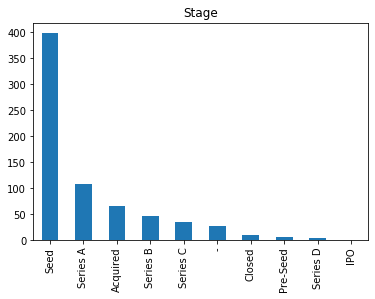

In [57]:
comp['stage'].value_counts().plot(kind='bar')
plt.title("Stage")
plt.show()

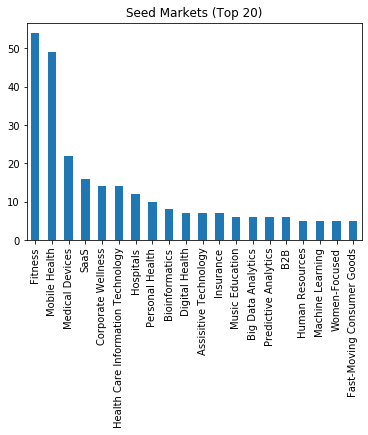

In [58]:
comp[comp['stage'] == "Seed"]['market'].value_counts()[:20].plot(kind='bar')
plt.title("Seed Markets (Top 20)")
plt.show()

In [59]:
comp.shape

(698, 11)

In [60]:
Counter([str(i)[0] for i in comp['raised']])

Counter({'$': 693, '€': 5})

In [61]:
def clean_currency(curr_string):
    curr_string=str(curr_string)
    curr_string = curr_string.replace(",","")
    curr_type = curr_string[0]
    curr_val = int(curr_string[1:])
    
    if curr_type == "$":
        return int(curr_val)
    elif curr_type == "€":
        return int(curr_val*1.11)
    elif curr_type == "£":
        return int(curr_val*1.31)
    else: return int(curr_val)

In [62]:
comp['raised'] = comp['raised'].apply(lambda row: clean_currency(row))

In [63]:
comp.head()

,kind,link,name,pitch,joined,location,market,size,stage,raised,website
1,Startup,https://angel.co/company/drchrono,DrChrono,\nOn a mission to fix healthcare\n,Feb ’11,Sunnyvale,Medical Devices,51-200,Series A,48725000,drchrono.com
2,Startup,https://angel.co/company/classpass,ClassPass,\nOne app for the best fitness classes\n,Jul ’11,Sydney,Fitness,501-1000,Series C,84000000,classpass.com
3,Startup,https://angel.co/company/fabricgenomics,Fabric Genomics,\nGlobal healthcare platform for genomics-driv...,Jul ’13,Oakland,Bioinformatics,11-50,Series B,23000000,fabricgenomics.com
4,Startup,https://angel.co/company/chewse,Chewse,"\nProvides hassle-free, locally-sourced, delic...",Jan ’12,Austin,Hospitality,51-200,Series B,16000000,chewse.com
5,Startup,https://angel.co/company/syapse,Syapse,\nPowering precision medicine with insights fr...,Feb ’12,Radnor,Bioinformatics,51-200,Series C,59500000,syapse.com


In [64]:
comp['size'].unique().tolist()

['51-200', '501-1000', '11-50', '201-500', '1-10', nan, '-']

In [65]:
import datetime

x = datetime.datetime(2020, 5, 1)

print(x)

2020-05-01 00:00:00


In [66]:

m={'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
def clean_date(curr_date):
    mo,year = (curr_date.split(' ’'))
    return(datetime.datetime(int('20'+year), m[mo], 1))

In [67]:
def year_estd(date):
    now = datetime.datetime(2020,5,25,0,0,0,0)
    diff = now - date
    return (diff.days/365)

In [68]:
comp['joined'] = comp['joined'].apply(lambda row: clean_date(row))

In [69]:
comp['years'] = comp['joined'].apply(lambda row: year_estd(row))

In [71]:
comp['annual_raised'] = comp['raised']/comp['years']

In [73]:
comp['raised_2mil'] = comp['raised'].apply(lambda row: 1 if row>2000000 else 0)

In [74]:
comp['raised_12mil'] = comp['raised'].apply(lambda row: 1 if row>12000000 else 0)

In [75]:
size_dic={}
size_dic['1-10'] = 5
size_dic['11-50'] = 25
size_dic['51-200'] = 125
size_dic['201-500'] = 350
size_dic['501-1000'] = 750
size_dic['1001-5000'] = 3000
size_dic['5000+'] = 8000
size_dic['-'] = np.nan
size_dic[np.nan] = np.nan
size_dic

{'1-10': 5,
 '11-50': 25,
 '51-200': 125,
 '201-500': 350,
 '501-1000': 750,
 '1001-5000': 3000,
 '5000+': 8000,
 '-': nan,
 nan: nan}

In [76]:
comp['size_numeric'] = comp['size'].apply(lambda row: size_dic[row])

In [77]:
comp.head()

,kind,link,name,pitch,joined,location,market,size,stage,raised,website,years,annual_raised,raised_2mil,raised_12mil,size_numeric
1,Startup,https://angel.co/company/drchrono,DrChrono,\nOn a mission to fix healthcare\n,2011-02-01,Sunnyvale,Medical Devices,51-200,Series A,48725000,drchrono.com,9.317808,5.229234e+06,1,1,125.0
2,Startup,https://angel.co/company/classpass,ClassPass,\nOne app for the best fitness classes\n,2011-07-01,Sydney,Fitness,501-1000,Series C,84000000,classpass.com,8.906849,9.430944e+06,1,1,750.0
3,Startup,https://angel.co/company/fabricgenomics,Fabric Genomics,\nGlobal healthcare platform for genomics-driv...,2013-07-01,Oakland,Bioinformatics,11-50,Series B,23000000,fabricgenomics.com,6.904110,3.331349e+06,1,1,25.0
4,Startup,https://angel.co/company/chewse,Chewse,"\nProvides hassle-free, locally-sourced, delic...",2012-01-01,Austin,Hospitality,51-200,Series B,16000000,chewse.com,8.402740,1.904141e+06,1,1,125.0
5,Startup,https://angel.co/company/syapse,Syapse,\nPowering precision medicine with insights fr...,2012-02-01,Radnor,Bioinformatics,51-200,Series C,59500000,syapse.com,8.317808,7.153327e+06,1,1,125.0


In [78]:
comp.groupby("raised_2mil").count()

,kind,link,name,pitch,joined,location,market,size,stage,raised,website,years,annual_raised,raised_12mil,size_numeric
raised_2mil,,,,,,,,,,,,,,,
0,353,353,353,353,353,353,353,349,353,353,353,353,353,353,346
1,345,345,345,345,345,345,331,344,345,345,344,345,345,345,344


In [79]:
comp.groupby("raised_12mil").count()

,kind,link,name,pitch,joined,location,market,size,stage,raised,website,years,annual_raised,raised_2mil,size_numeric
raised_12mil,,,,,,,,,,,,,,,
0,566,566,566,566,566,566,554,561,566,566,565,566,566,566,558
1,132,132,132,132,132,132,130,132,132,132,132,132,132,132,132


In [81]:
comp.to_csv('C:/Users/daswa/Desktop/Data Science Projects/Healthcare_Startup_Assessment/data/processed/companies.csv')